In [1]:
import json

import tqdm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

import os
base_dir = os.path.realpath('.')
data_dir = f"{base_dir}/dendrite_data"

### Load data

Full synapse morphology and synapses are available on www.microns-explorer.org, but too large for use in a binder.

#### Column descriptions:
##### dends_df

* bin_num : Integer index of the bin. 0 corresponds to the soma, 1 to the first 15 µm bin, etc.
* oid : Root id of the cell
* bin_surface : Total amount of surface area in the bin as computed from the unsmoothed mesh (in µm^2).
* bin_len : Total cable length in the bin from the skeleton (in µm).
* bin_size : List of synapse sizes (in voxels) for all synapses in the bin.
* bin_from_e : List of boolean values if the synapse is from an pyramidal cell.
* bin_syn_id : Index in the meshwork input synapse dataframe for the cell (see microns-explorer.org).
* median_rad : Median diameter in nm (yes, not radius --- sorry about that), as computed from a ray casting implementation of the shape diameter function.
* bin_dist : Distance of the center of the bin from the soma (e.g. 7.5 corresponds to a bin between 0-15 µm). The soma value is -7.5 for convenience, but should be treated as 0.
* bin_qc : Boolean value if the bin has at least 7.5 µm of cable in it.
* cell_type : Type of the cell, as noted in the paper.
* mean_logsyn : Average log10-transformed synapse size in the bin.
* median_syn : Median synapse size in the bin.
* syn_per_um : Number of synapses per linear µm of cable in the bin.
* syn_per_um2 : Number of synapses per µm^2 surface area in the bin.
* surface_per_length : Surface area of the bin divided by cable length in the bin.

In [2]:
dends_df = pd.read_hdf(f'{data_dir}/dend_df_scaled.h5', 'smoothed_plus')
dends_df['bin_qc'] = np.logical_and(dends_df['bin_qc'], dends_df['bin_len'] > 7.5)

# Only work on cells with good bin qc and proximity to the soma.
dends_df_nr = dends_df.query('bin_qc == 1 and bin_num < 11')

nrn_df = pd.read_hdf(f'{data_dir}/nrn_df.h5', 'data')

### Set visual parameters

In [3]:
import matplotlib as mpl

def set_rc_params(mpl):
    mpl.rcParams['pdf.fonttype'] = 42
    mpl.rcParams['font.sans-serif'] = ['Helvetica', 'Helvetica Neue']
set_rc_params(mpl)

hue_order = ['basket', 'chandelier', 'bipolar', 'martinotti', 'neurogliaform', 'e']

current_palette = sns.color_palette()
current_palette[6] = [0.7, 0.7, 0.7]
current_palette[5] = [0,0,0]
pal_dict = {h:current_palette[ii] for ii, h in enumerate(hue_order+['unknown_type'])}

types = ['basket', 'chandelier', 'bipolar', 'martinotti', 'neurogliaform', 'e']

xticks = np.arange(10,151,25)
xticks_soma = np.concatenate([np.array([-7.5]), xticks])
xtick_soma_labels = ['Soma'] + [str(x) for x in xticks]
pd.set_option('use_inf_as_na', True)

### Linear synapse density

1) For cells grouped by subtype

Text(0, 0.5, 'Synapses per $\\mu m$')

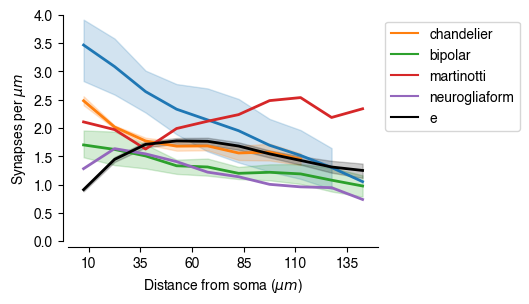

In [4]:
fig, ax = plt.subplots(figsize=(4,3), dpi=100, facecolor='w')

sns.lineplot(x='bin_dist', y='syn_per_um', hue='cell_type', data=dends_df_nr.query('cell_type !="unknown_type" and bin_dist > 0'), palette=pal_dict, hue_order=hue_order, lw=2, ax=ax)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:]).set_bbox_to_anchor((1,1))

sns.despine(ax=ax, offset=4)
ax.set_xlim(0, 150)
ax.set_ylim(0, 4)
ax.set_xticks(xticks)
ax.set_xlabel('Distance from soma ($\mu m$)')
ax.set_ylabel('Synapses per $\mu m$')

2) For all cells individually

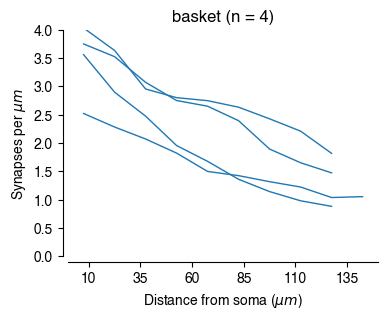

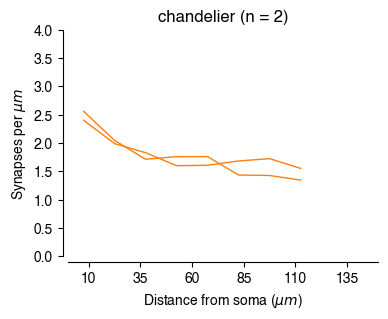

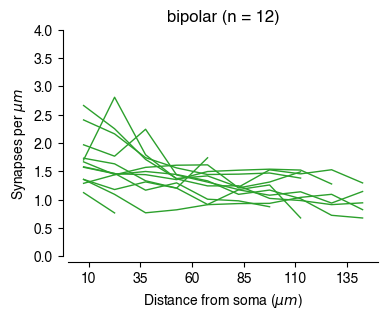

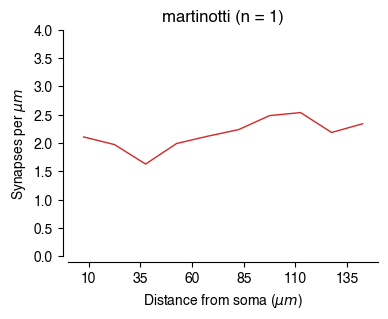

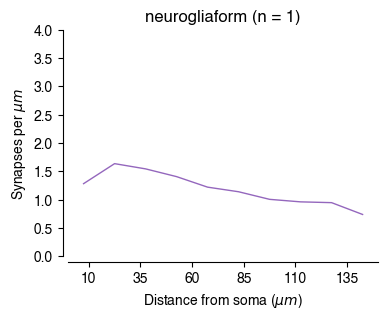

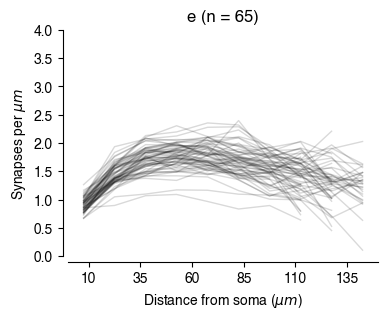

In [5]:
for ty in types:
    fig, ax = plt.subplots(figsize=(4,3), dpi=100, facecolor='w')

    if ty == 'e':
        opacity = 0.15
    else:
        opacity = 1

    sns.lineplot(x='bin_dist', y='syn_per_um', hue='cell_type', data=dends_df_nr.query(f'cell_type==@ty and bin_dist>0'), ax=ax, palette=pal_dict, hue_order=hue_order, estimator=None, units='oid', lw=1, legend=False, alpha=opacity)
    # sns.lineplot(x='bin_dist', y='syn_per_um', hue='cell_type', data=dends_df_nr.query(f'cell_type == @ty'), hue_order=hue_order, estimator='mean', ci=None, lw=2, ax=ax, legend=False)

    sns.despine(ax=ax, offset=4)
    ax.set_xlim(0,150)
    ax.set_ylim(0,4)
    ax.set_xticks(xticks)

    ax.set_title(f"{ty} (n = {len(np.unique(dends_df_nr.query(f'cell_type == @ty')['oid']))})" )
    ax.set_xlabel('Distance from soma ($\mu m$)')
    ax.set_ylabel('Synapses per $\mu m$')

### Area-based synapse density

1) Per cell type

(0.0, 0.9)

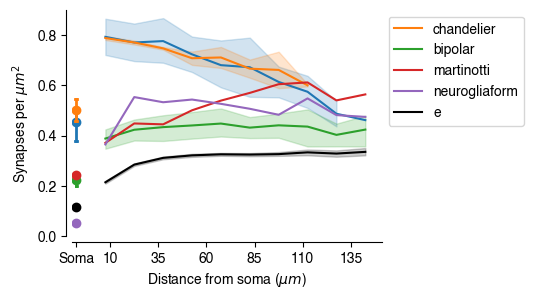

In [6]:
fig, ax = plt.subplots(figsize=(4,3), dpi=100, facecolor='w')

g = sns.pointplot(x='bin_dist', y='syn_per_um2', hue='cell_type', dodge=True, data=dends_df_nr.query('cell_type !="unknown_type" and bin_dist<-7'), scale=0.8, capsize=1, orient='v', errwidth=2, palette=pal_dict, hue_order=hue_order, ax=ax, legend=False)

for ll in g.lines:
    ll.set_xdata(ll.get_xdata()-7.5)

try_pcs = []
for pc in g.get_children():
    if isinstance(pc, mpl.collections.PathCollection):
        pc.set_offset_position('data')
        x1, y1 = pc.get_offsets()[0]
        pc.set_offsets(np.array([-7.5, y1]).reshape(1,2))

sns.lineplot(x='bin_dist', y='syn_per_um2', hue='cell_type', data=dends_df_nr.query('cell_type !="unknown_type" and bin_dist>0'), palette=pal_dict, hue_order=hue_order, ax=ax)

ax.legend(handles=handles[1:], labels=labels[1:]).set_bbox_to_anchor((1,1))
ax.set_xlim(-10,151)
ax.set_xticks(xticks_soma)
ax.set_xticklabels(xtick_soma_labels)
sns.despine(ax=ax, offset=4)

ax.set_xlabel('Distance from soma ($\mu m$)')
ax.set_ylabel('Synapses per $\mu m^2$')
ax.set_ylim(0, 0.9)

2) For each cell individually

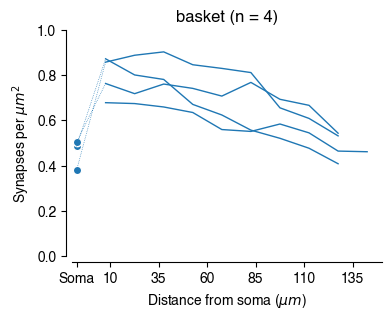

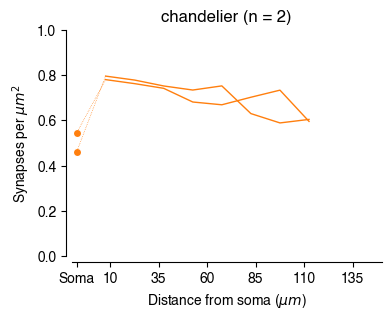

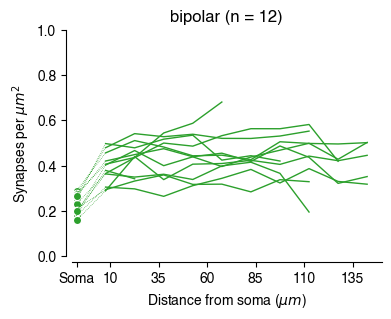

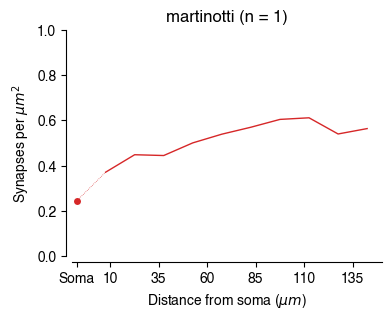

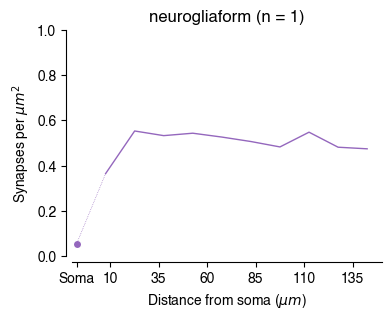

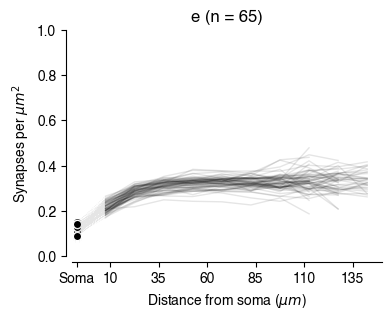

In [7]:
for ty in types:

    fig, ax = plt.subplots(figsize=(4,3), dpi=100, facecolor='w')
    if ty == 'e':
        opacity = 0.1
    else:
        opacity = 1

    g=sns.lineplot(x='bin_dist', y='syn_per_um2', hue='cell_type', palette=pal_dict, data=dends_df_nr.query('cell_type ==@ty and bin_dist>0'), ax=ax, estimator=None, units='oid', hue_order=hue_order, lw=1, legend=False, alpha=opacity)
    l=ax.plot(dends_df_nr.query('cell_type ==@ty and bin_dist<0')['bin_dist'], dends_df_nr.query('cell_type ==@ty and bin_dist<0')['syn_per_um2'], marker='o', markeredgecolor='w', color=g.lines[0].get_color(), linestyle='')
    
    xs = dends_df_nr.query('cell_type ==@ty and bin_dist<8')['bin_dist']
    ys = dends_df_nr.query('cell_type ==@ty and bin_dist<8')['syn_per_um2']
    ax.plot(np.insert(xs.values, np.arange(2,len(xs),2), np.nan), np.insert(ys.values, np.arange(2,len(ys),2), np.nan), marker=None, color=l[0].get_color(), lw=0.5, alpha=opacity, linestyle=':')

    sns.despine(ax=ax, offset=4)
    ax.set_xlim(-10,150)
    ax.set_xticks(xticks_soma)
    ax.set_xticklabels(xtick_soma_labels)
    ax.set_xlabel('Distance from soma ($\mu m$)')
    ax.set_ylabel('Synapses per $\mu m^2$')
    ax.set_ylim(0, 1)
    ax.set_title(f"{ty} (n = {len(np.unique(dends_df_nr.query(f'cell_type == @ty')['oid']))})" )

3) For putative PV cells (basket and chandelier cells)

Text(0.5, 1.0, 'Putative PVs')

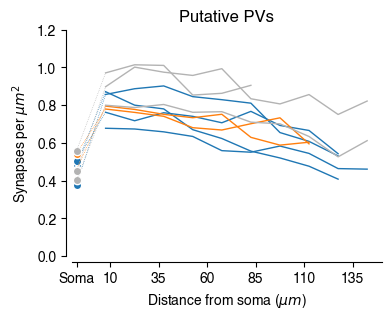

In [8]:
putative_bs = [648518346349517783, 648518346349536849]
putative_cs = [648518346349522750]
putative_pv = putative_bs + putative_cs

fig, ax = plt.subplots(figsize=(4,3), dpi=100, facecolor='w')
opacity=1

ty='basket'
g=sns.lineplot(x='bin_dist', y='syn_per_um2', hue='cell_type', data=dends_df_nr.query('cell_type ==@ty and bin_dist>0'), palette=pal_dict, ax=ax, estimator=None, units='oid', hue_order=hue_order, lw=1, legend=False, alpha=opacity)
    # sns.pointplot(x='bin_dist', y='syn_per_um2', hue='cell_type', data=dends_df_nr.query('cell_type == @ty'), ax=ax, estimator=None, units='oid', hue_order=hue_order, lw=1, legend=False)
l=ax.plot(dends_df_nr.query('cell_type ==@ty and bin_dist<0')['bin_dist'], dends_df_nr.query('cell_type ==@ty and bin_dist<0')['syn_per_um2'], marker='o', markeredgecolor='w', color=g.lines[0].get_color(), linestyle='')

xs = dends_df_nr.query('cell_type ==@ty and bin_dist<8')['bin_dist']
ys = dends_df_nr.query('cell_type ==@ty and bin_dist<8')['syn_per_um2']
ax.plot(np.insert(xs.values, np.arange(2,len(xs),2), np.nan), np.insert(ys.values, np.arange(2,len(ys),2), np.nan), marker=None, color=l[0].get_color(), lw=0.5, alpha=opacity, linestyle=':')

last_line = len(g.lines)
####

ty='chandelier'
g=sns.lineplot(x='bin_dist', y='syn_per_um2', hue='cell_type', data=dends_df_nr.query('cell_type ==@ty and bin_dist>0'), palette=pal_dict, ax=ax, estimator=None, units='oid', hue_order=hue_order, lw=1, legend=False, alpha=opacity)
    # sns.pointplot(x='bin_dist', y='syn_per_um2', hue='cell_type', data=dends_df_nr.query('cell_type == @ty'), ax=ax, estimator=None, units='oid', hue_order=hue_order, lw=1, legend=False)
l=ax.plot(dends_df_nr.query('cell_type ==@ty and bin_dist<0')['bin_dist'], dends_df_nr.query('cell_type ==@ty and bin_dist<0')['syn_per_um2'], marker='o', markeredgecolor='w', color=g.lines[last_line].get_color(), linestyle='')

xs = dends_df_nr.query('cell_type ==@ty and bin_dist<8')['bin_dist']
ys = dends_df_nr.query('cell_type ==@ty and bin_dist<8')['syn_per_um2']
ax.plot(np.insert(xs.values, np.arange(2,len(xs),2), np.nan), np.insert(ys.values, np.arange(2,len(ys),2), np.nan), marker=None, color=l[0].get_color(), lw=0.5, alpha=opacity, linestyle=':')


sns.despine(ax=ax, offset=4)
ax.set_xlim(-10,150)
ax.set_xticks(xticks_soma)
ax.set_xticklabels(xtick_soma_labels)
ax.set_xlabel('Distance from soma ($\mu m$)')
ax.set_ylabel('Synapses per $\mu m^2$')
ax.set_ylim(0, 1)
ax.set_title(f"Putative PVs")

next_last_line = len(g.lines)
####

g=sns.lineplot(x='bin_dist', y='syn_per_um2', hue='cell_type', data=dends_df_nr.query(f'oid in {putative_pv} and bin_dist>0'), palette=pal_dict, ax=ax, estimator=None, units='oid', lw=1, legend=False, alpha=opacity)
    # sns.pointplot(x='bin_dist', y='syn_per_um2', hue='cell_type', data=dends_df_nr.query('cell_type == @ty'), ax=ax, estimator=None, units='oid', hue_order=hue_order, lw=1, legend=False)
l=ax.plot(dends_df_nr.query(f'oid in {putative_pv} and bin_dist<0')['bin_dist'], dends_df_nr.query(f'oid in {putative_pv}  and bin_dist<0')['syn_per_um2'], marker='o', markeredgecolor='w', color=g.lines[next_last_line].get_color(), linestyle='')

xs = dends_df_nr.query(f'oid in {putative_pv} and bin_dist<8')['bin_dist']
ys = dends_df_nr.query(f'oid in {putative_pv} and bin_dist<8')['syn_per_um2']
ax.plot(np.insert(xs.values, np.arange(2,len(xs),2), np.nan), np.insert(ys.values, np.arange(2,len(ys),2), np.nan), marker=None, color=l[0].get_color(), lw=0.5, alpha=opacity, linestyle=':')

sns.despine(ax=ax, offset=4)
ax.set_xlim(-10,150)
ax.set_xticks(xticks_soma)
ax.set_xticklabels(xtick_soma_labels)
ax.set_xlabel('Distance from soma ($\mu m$)')
ax.set_ylabel('Synapses per $\mu m^2$')
ax.set_ylim(0, 1.2)
ax.set_title(f"Putative PVs")

Statistical comparison of the pv-cell types to the non-pv cell types:

In [9]:
syn_per_um2_pv = dends_df_nr.query('bin_dist>0 and bin_dist<=85 and cell_type in ["basket", "chandelier"]').groupby(['oid', 'bin_dist']).mean()['syn_per_um2'].reset_index()
syn_per_um2_non = dends_df_nr.query('bin_dist>0 and bin_dist<=85 and cell_type in ["bipolar", "martinotti", "neurogliaform"]').groupby(['oid', 'bin_dist']).mean()['syn_per_um2'].reset_index()

res_p = []
bds = np.unique(syn_per_um2_pv['bin_dist'])
for bd in bds:
    res_p.append( stats.mannwhitneyu(syn_per_um2_pv.query('bin_dist==7.5')['syn_per_um2'],
                   syn_per_um2_non.query('bin_dist==7.5')['syn_per_um2'], alternative='two-sided', ).pvalue )

import statsmodels.api as sm

display(sm.stats.multipletests(res_p))

(array([ True,  True,  True,  True,  True,  True]),
 array([0.00371217, 0.00371217, 0.00371217, 0.00371217, 0.00371217,
        0.00371217]),
 0.008512444610847103,
 0.008333333333333333)

### Median Synapse Size

1) For cells grouped by cell type

(100.0, 450.0)

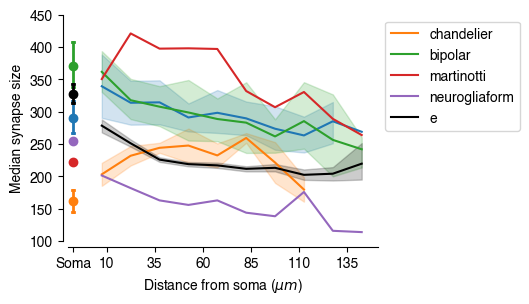

In [10]:
fig, ax = plt.subplots(figsize=(4,3), dpi=100, facecolor='w')

g = sns.pointplot(x='bin_dist', y='median_syn', hue='cell_type', dodge=True, data=dends_df_nr.query('cell_type !="unknown_type" and bin_dist<-7'), palette=pal_dict, scale=0.8, capsize=1, orient='v', errwidth=2, hue_order=hue_order, ax=ax, legend=False)

for ll in g.lines:
    ll.set_xdata(ll.get_xdata()-7.5)

try_pcs = []
for pc in g.get_children():
    if isinstance(pc, mpl.collections.PathCollection):
        pc.set_offset_position('data')
        x1, y1 = pc.get_offsets()[0]
        pc.set_offsets(np.array([-7.5, y1]).reshape(1,2))

sns.lineplot(x='bin_dist', y='median_syn', hue='cell_type', data=dends_df_nr.query('cell_type !="unknown_type" and bin_dist>0'), palette=pal_dict, hue_order=hue_order, ax=ax)

ax.legend(handles=handles[1:], labels=labels[1:]).set_bbox_to_anchor((1,1))
ax.set_xlim(-10,151)
ax.set_xticks(xticks_soma)
ax.set_xticklabels(xtick_soma_labels)
sns.despine(ax=ax, offset=4)

ax.set_xlabel('Distance from soma ($\mu m$)')
ax.set_ylabel('Median synapse size')
ax.set_ylim(100, 450)

2) For all cells individually

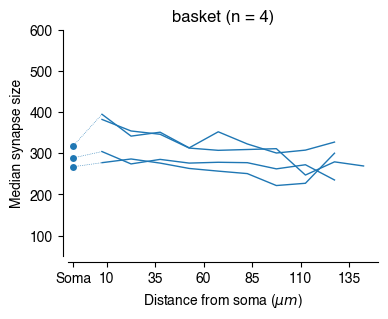

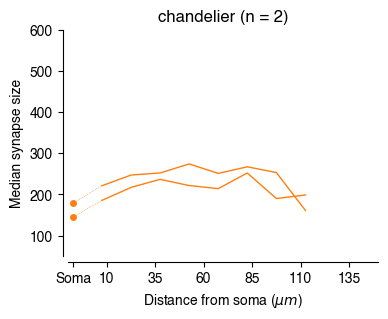

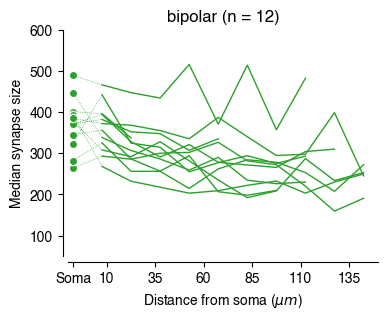

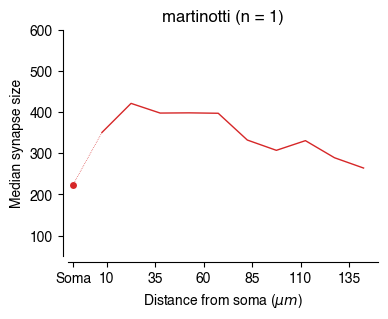

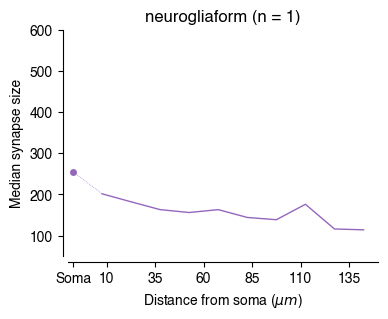

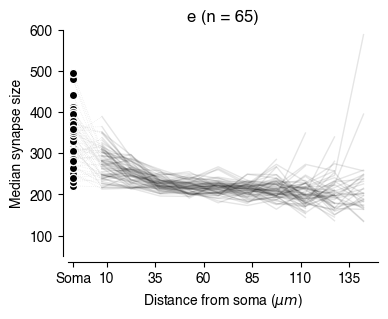

In [11]:
for ty in types:

    fig, ax = plt.subplots(figsize=(4,3), dpi=100, facecolor='w')
    
    if ty == 'e':
        opacity = 0.1
    else:
        opacity = 1

    g=sns.lineplot(x='bin_dist', y='median_syn', hue='cell_type', data=dends_df_nr.query('cell_type ==@ty and bin_dist>0'), ax=ax, estimator=None, units='oid', palette=pal_dict, hue_order=hue_order, lw=1, alpha=opacity, legend=False)
    # sns.pointplot(x='bin_dist', y='syn_per_um2', hue='cell_type', data=dends_df_nr.query('cell_type == @ty'), ax=ax, estimator=None, units='oid', hue_order=hue_order, lw=1, legend=False)
    l=ax.plot(dends_df_nr.query('cell_type ==@ty and bin_dist<0')['bin_dist'], dends_df_nr.query('cell_type ==@ty and bin_dist<0')['median_syn'], marker='o', markeredgecolor='w', color=g.lines[0].get_color(), linestyle='')
    xs = dends_df_nr.query('cell_type ==@ty and bin_dist<8')['bin_dist']
    ys = dends_df_nr.query('cell_type ==@ty and bin_dist<8')['median_syn']
    ax.plot(np.insert(xs.values, np.arange(2,len(xs),2), np.nan), np.insert(ys.values, np.arange(2,len(ys),2), np.nan), marker=None, color=l[0].get_color(), alpha=opacity, lw=0.5, linestyle=':')

    sns.despine(ax=ax, offset=4)
    ax.set_xlim(-10,150)
    ax.set_xticks(xticks_soma)
    ax.set_xticklabels(xtick_soma_labels)
    ax.set_xlabel('Distance from soma ($\mu m$)')
    ax.set_ylabel('Median synapse size')
    ax.set_ylim(50, 600)
    ax.set_title(f"{ty} (n = {len(np.unique(dends_df_nr.query(f'cell_type == @ty')['oid']))})" )

### Total number of synpases per bin

Text(0, 0.5, 'Net synapses per bin')

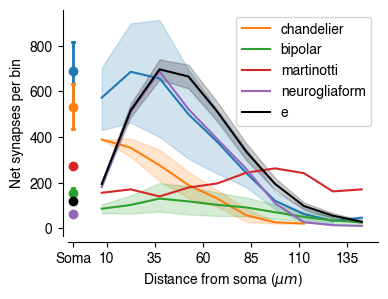

In [12]:
fig, ax = plt.subplots(figsize=(4,3), dpi=100, facecolor='w')

g = sns.pointplot(x='bin_dist', y='bin_synapse', hue='cell_type', dodge=True, data=dends_df_nr.query('cell_type !="unknown_type" and bin_dist<-7'), scale=0.8, palette=pal_dict, capsize=1, orient='v', errwidth=2, hue_order=hue_order, ax=ax, legend=False)

for ll in g.lines:
    ll.set_xdata(ll.get_xdata()-7.5)

try_pcs = []
for pc in g.get_children():
    if isinstance(pc, mpl.collections.PathCollection):
        pc.set_offset_position('data')
        x1, y1 = pc.get_offsets()[0]
        pc.set_offsets(np.array([-7.5, y1]).reshape(1,2))

sns.lineplot(x='bin_dist', y='bin_synapse', hue='cell_type', data=dends_df_nr.query('cell_type !="unknown_type" and bin_dist>0'), palette=pal_dict, hue_order=hue_order, ax=ax)

ax.legend(handles=handles[1:], labels=labels[1:]).set_bbox_to_anchor((1,1))
ax.set_xlim(-10,151)
ax.set_xticks(xticks_soma)
ax.set_xticklabels(xtick_soma_labels)
sns.despine(ax=ax, offset=4)

ax.set_xlabel('Distance from soma ($\mu m$)')
ax.set_ylabel('Net synapses per bin')

### Total cable length per bin

Text(0, 0.5, 'Net length/cell in bin ($\\mu m$)')

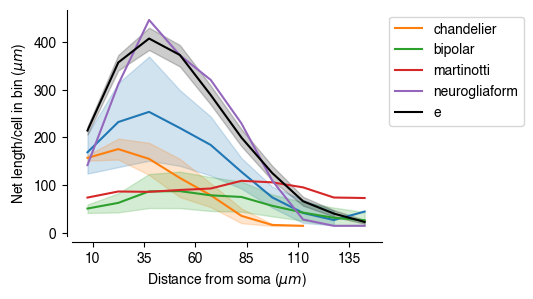

In [13]:
fig, ax = plt.subplots(figsize=(4,3), dpi=100, facecolor='w')

sns.lineplot(x='bin_dist', y='bin_len', hue='cell_type', data=dends_df_nr.query('cell_type !="unknown_type" and bin_dist>0'), palette=pal_dict, hue_order=hue_order, ax=ax)

ax.legend(handles=handles[1:], labels=labels[1:]).set_bbox_to_anchor((1,1))
ax.set_xlim(0,151)
ax.set_xticks(xticks)
sns.despine(ax=ax, offset=4)

ax.set_xlabel('Distance from soma ($\mu m$)')
ax.set_ylabel('Net length/cell in bin ($\mu m$)')


### Synapse size distributions by compartment

First, we pool the data that was in the `dends_df` dataframe and then we plot it by compartment and cell type using seaborn violinplots.

In [14]:
oid_long = []
bn_long = []
bs_id_long = []
size_long = []
bd_long = []
ct_long = []
fe_long = []

for _, row in dends_df.iterrows():
    size_long.append(row['bin_size'])
    bs_id_long.append(row['bin_syn_id'])
    oid_long.append(np.full(len(row['bin_size']), row['oid']))
    bn_long.append(np.full(len(row['bin_size']), row['bin_num']))
    bd_long.append(np.full(len(row['bin_size']), row['bin_dist']))
    ct_long.append(np.full(len(row['bin_size']), row['cell_type']))
    fe_long.append(np.full(len(row['bin_size']), row['bin_from_e']))
    
oid_long = np.concatenate(oid_long)
bn_long = np.concatenate(bn_long)
bs_id_long = np.concatenate(bs_id_long)
size_long = np.concatenate(size_long)
bd_long = np.concatenate(bd_long)
ct_long = np.concatenate(ct_long)
fe_long = np.concatenate(fe_long).astype(bool)

syn_long_df = pd.DataFrame(data={'oid': oid_long,
                   'bin_num': bn_long,
                   'syn_id': bs_id_long,
                   'size': size_long,
                   'bin_dist': bd_long,
                   'cell_type': ct_long,
                   'from_e': fe_long,
                   })

syn_long_df['logsize'] = np.log10(syn_long_df['size'])

Text(0.5, 0, '')

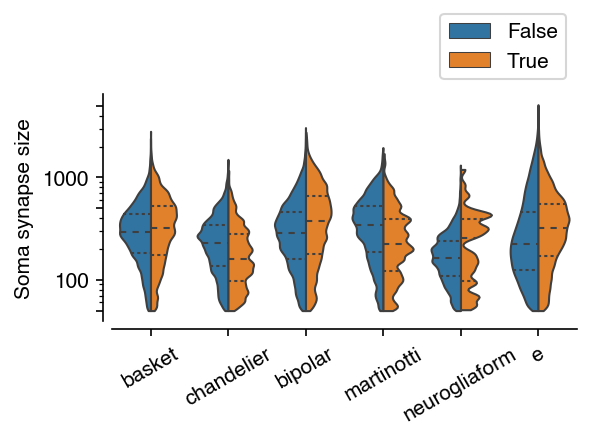

In [15]:
syn_long_df['is_soma'] = syn_long_df['bin_dist']<0

fig, ax = plt.subplots(figsize=(4,2), facecolor='w', dpi=150)
pal_dict_mod = pal_dict.copy()
pal_dict_mod['e'] = [0.5, 0.5, 0.5]

ax = sns.violinplot(x='cell_type', y='logsize', inner='quartile', hue='is_soma', order=hue_order, linewidth=1, bw=0.1, clip=[np.log10(50), np.inf], cut=0,
                    data=syn_long_df.query('cell_type != "unknown_type"'), split=True)


ax.legend().set_bbox_to_anchor((1,1.4))

ax.set_yscale('linear')
ax.set_yticks(np.log10([50, 100, 500, 1000, 5000]),
              minor=False)
ax.set_yticks(np.log10([60, 70, 80, 90, 200, 300, 400, 600, 700, 800, 900, 2000 ,3000, 4000]),
              minor=True)
ax.set_yticklabels(['', 100, '', 1000, ''])

sns.despine(ax=ax, offset=4)
ax.set_ylabel('Soma synapse size')
for l in ax.get_xticklabels():
    l.set_rotation(30)

ax.set_xlabel('')

MannwhitneyuResult(statistic=691731944.5, pvalue=3.576023042391485e-121)


[]

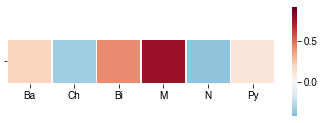

In [16]:
def cohen_d(xx, yy):
    num = np.nanmean(xx)-np.nanmean(yy)
    den = np.sqrt( ((len(xx)-1) * np.std(xx)**2 + (len(yy)-1) * np.std(yy)**2) / (len(xx) + len(yy) -2) )
    return num/den

ty = '"basket"'
xx = syn_long_df.query(f'cell_type == {ty} and is_soma == True')['size']
yy = syn_long_df.query(f'cell_type == {ty} and is_soma == False')['size']
bsk_ttest = stats.mannwhitneyu(xx, yy)
bsk_d = cohen_d(xx, yy)

ty = '"chandelier"'
xx = syn_long_df.query(f'cell_type == {ty} and is_soma == True')['size']
yy = syn_long_df.query(f'cell_type == {ty} and is_soma == False')['size']
chc_ttest = stats.mannwhitneyu(xx, yy, )
chc_d = cohen_d(xx, yy)

ty = '"bipolar"'
xx = syn_long_df.query(f'cell_type == {ty} and is_soma == True')['size']
yy = syn_long_df.query(f'cell_type == {ty} and is_soma == False')['size']
bip_ttest = stats.mannwhitneyu(xx, yy)
bip_d = cohen_d(xx, yy)

ty = '"neurogliaform"'
xx = syn_long_df.query(f'cell_type == {ty} and is_soma == True')['size']
yy = syn_long_df.query(f'cell_type == {ty} and is_soma == False')['size']
ngl_ttest = stats.mannwhitneyu(xx, yy,)
ngl_d = cohen_d(xx, yy)

ty = '"martinotti"'
xx = syn_long_df.query(f'cell_type == {ty} and is_soma == True')['size']
yy = syn_long_df.query(f'cell_type == {ty} and is_soma == False')['size']
mart_ttest = stats.mannwhitneyu(xx, yy)
mart_d = cohen_d(xx, yy)

ty = '"e"'
xx = syn_long_df.query(f'cell_type == {ty} and is_soma == True')['size']
yy = syn_long_df.query(f'cell_type == {ty} and is_soma == False')['size']
e_ttest = stats.mannwhitneyu(xx, yy)
e_d = cohen_d(xx, yy)

import statsmodels.stats.api as sm
ds_df=pd.DataFrame({'cell_type': ['basket', 'chandelier', 'bipolar', 'neurogliaform', 'martinotti', 'e'],
              'pvalue': sm.multipletests([bsk_ttest.pvalue, chc_ttest.pvalue, bip_ttest.pvalue, ngl_ttest.pvalue, mart_ttest.pvalue, e_ttest.pvalue])[1] ,
              'cohen_d': [bsk_d, chc_d, bip_d, ngl_d, mart_d, e_d]})


xx = syn_long_df.query(f'cell_type == {ty} and is_soma == True')['size']
yy = syn_long_df.query(f'cell_type == {ty} and is_soma == False')['size']
print(stats.mannwhitneyu(xx, yy, ))

fig, ax = plt.subplots(1,1, facecolor='w')
sns.heatmap( ds_df['cohen_d'].values.reshape(1,6), cmap='RdBu_r', vmax=0.9, vmin=-0.4, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
ax.set_xticklabels(['Ba', 'Ch', 'Bi', 'M', 'N', 'Py'])
ax.set_yticklabels('')

In [17]:
ct_1 = []
ct_2 = []
pv = []
cd = []

datdf = syn_long_df.query('is_soma==False')

for ii in np.arange(len(hue_order)):
    for jj in np.arange(ii+1,len(hue_order)):
        ct_1.append(hue_order[ii])
        ct_2.append(hue_order[jj])
        x=datdf.query(f'cell_type=="{hue_order[ii]}"')['size']
        y=datdf.query(f'cell_type=="{hue_order[jj]}"')['size']
        pv.append(stats.mannwhitneyu(x, y).pvalue)
        cd.append(cohen_d(x,y))
        
dend_pair_df = pd.DataFrame({'cell_type_a': ct_1,
                        'cell_type_b': ct_2,
                        'p_value':sm.multipletests(pv)[1],
                        'passes':sm.multipletests(pv)[0],
                        'cohen_d': cd})

#### Soma #####
ct_1 = []
ct_2 = []
pv = []
cd = []

datdf = syn_long_df.query('is_soma==True')

for ii in np.arange(len(hue_order)):
    for jj in np.arange(ii+1,len(hue_order)):
        ct_1.append(hue_order[ii])
        ct_2.append(hue_order[jj])
        x=datdf.query(f'cell_type=="{hue_order[ii]}"')['size']
        y=datdf.query(f'cell_type=="{hue_order[jj]}"')['size']
        pv.append(stats.mannwhitneyu(x, y).pvalue)
        cd.append(cohen_d(x,y))
        
soma_pair_df = pd.DataFrame({'cell_type_a': ct_1,
                        'cell_type_b': ct_2,
                        'p_value':sm.multipletests(pv)[1],
                        'passes':sm.multipletests(pv)[0],
                        'cohen_d': cd})




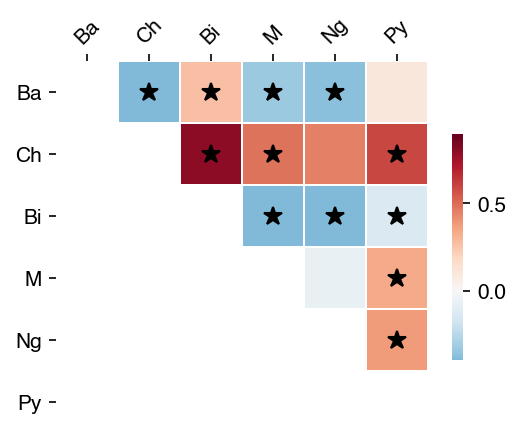

In [18]:
ct_labels = {'basket': 'Ba', 'chandelier': 'Ch', 'bipolar': 'Bi', 'martinotti':'M', 'neurogliaform': 'Ng', 'e': 'Py'}

Cds = np.zeros((len(hue_order), len(hue_order)))

cd = soma_pair_df['cohen_d'].values
Cds[np.triu_indices(len(hue_order), k=1)] = cd

is_sig = soma_pair_df['passes'].values
Cd_sym = Cds + Cds.T
tri_inds = np.triu_indices_from(Cd_sym, k=1)
put_star = []
for ii, jj, sig in zip(*tri_inds, is_sig):
    if sig:
        put_star.append([jj, ii])
put_star = np.array(put_star)


mask = np.zeros_like(Cd_sym, dtype=np.bool)
mask[np.tril_indices_from(Cd_sym)] = True

fig, ax = plt.subplots(figsize=(4, 4), facecolor='w', dpi=150)
sns.heatmap(-Cd_sym, mask=mask, cmap='RdBu_r', vmax=0.9, vmin=-0.4, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
ax.plot(put_star[:,0]+0.5, put_star[:,1]+0.5, 'k*', markersize=9)
hue_order_mod = hue_order.copy()
hue_order_mod[-1] = 'e'
_=ax.set_yticklabels([ct_labels[x] for x in hue_order_mod], rotation=0)
_=ax.set_xticklabels([ct_labels[x] for x in hue_order_mod], rotation=45)
ax.xaxis.tick_top()

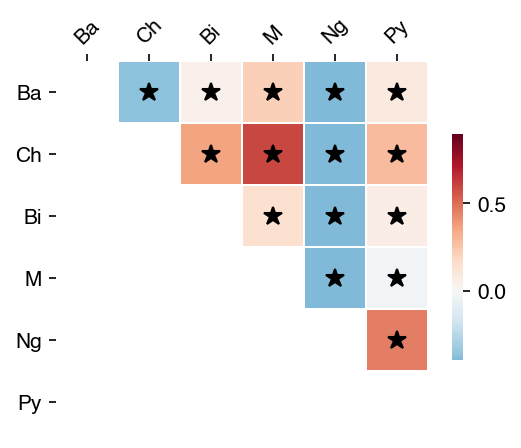

In [19]:

Cds = np.zeros((len(hue_order), len(hue_order)))

cd = dend_pair_df['cohen_d'].values
Cds[np.triu_indices(len(hue_order), k=1)] = cd

is_sig = dend_pair_df['passes'].values
Cd_sym = Cds + Cds.T
tri_inds = np.triu_indices_from(Cd_sym, k=1)
put_star = []
for ii, jj, sig in zip(*tri_inds, is_sig):
    if sig:
        put_star.append([jj, ii])
put_star = np.array(put_star)


mask = np.zeros_like(Cd_sym, dtype=np.bool)
mask[np.tril_indices_from(Cd_sym)] = True

fig, ax = plt.subplots(figsize=(4, 4), facecolor='w', dpi=150)
sns.heatmap(-Cd_sym, mask=mask, cmap='RdBu_r', vmax=0.9, vmin=-0.4, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
ax.plot(put_star[:,0]+0.5, put_star[:,1]+0.5, 'k*', markersize=9)

hue_order_mod = hue_order.copy()
hue_order_mod[-1] = 'e'
_=ax.set_yticklabels([ct_labels[x] for x in hue_order_mod], rotation=0)
_=ax.set_xticklabels([ct_labels[x] for x in hue_order_mod], rotation=45)
ax.xaxis.tick_top()

#### Dendritic inputs from pyramidal cells

Similar to the above analysis, but we filter the synapse dataframe to only be onto dendrites and only from pyramidal cells in the dataset.

No handles with labels found to put in legend.


Text(0.5, 0, '')

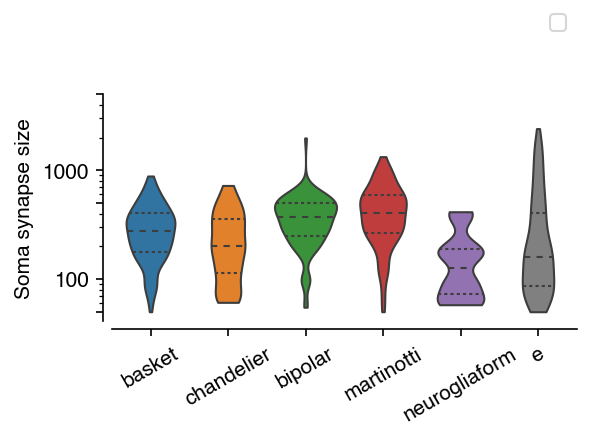

In [20]:
fig, ax = plt.subplots(figsize=(4,2), facecolor='w', dpi=150)
pal_dict_mod = pal_dict.copy()
pal_dict_mod['e'] = [0.5, 0.5, 0.5]

ax = sns.violinplot(x='cell_type', y='logsize', inner='quartile',palette=pal_dict_mod,
                    order=hue_order, linewidth=1, bw=0.3, clip=[np.log10(50), np.inf], cut=0,
                    data=syn_long_df.query('cell_type != "unknown_type" and is_soma==False and from_e == True'))


ax.legend().set_bbox_to_anchor((1,1.4))

ax.set_yscale('linear')
ax.set_yticks(np.log10([50, 100, 500, 1000, 5000]),
              minor=False)
ax.set_yticks(np.log10([60, 70, 80, 90, 200, 300, 400, 600, 700, 800, 900, 2000 ,3000, 4000]),
              minor=True)
ax.set_yticklabels(['', 100, '', 1000, ''])

sns.despine(ax=ax, offset=4)
ax.set_ylabel('Soma synapse size')
for l in ax.get_xticklabels():
    l.set_rotation(30)

ax.set_xlabel('')

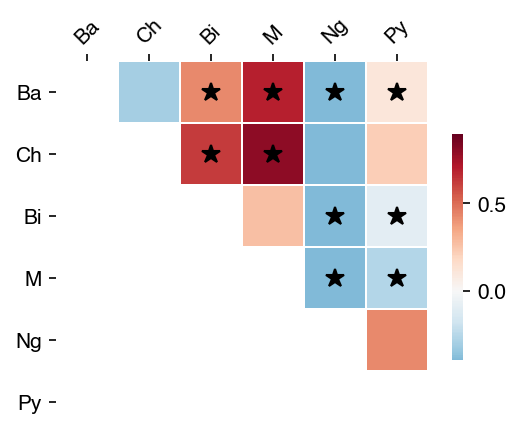

In [22]:
#### Soma #####
ct_1 = []
ct_2 = []
pv = []
cd = []

datdf = syn_long_df.query('is_soma==False and from_e==True')

for ii in np.arange(len(hue_order)):
    for jj in np.arange(ii+1,len(hue_order)):
        ct_1.append(hue_order[ii])
        ct_2.append(hue_order[jj])
        x=datdf.query(f'cell_type=="{hue_order[ii]}"')['size']
        y=datdf.query(f'cell_type=="{hue_order[jj]}"')['size']
        pv.append(stats.mannwhitneyu(x, y).pvalue)
        cd.append(cohen_d(x,y))
        
eonly_pair_df = pd.DataFrame({'cell_type_a': ct_1,
                        'cell_type_b': ct_2,
                        'p_value':sm.multipletests(pv)[1],
                        'passes':sm.multipletests(pv)[0],
                        'cohen_d': cd})


Cds = np.zeros((len(hue_order), len(hue_order)))

cd = eonly_pair_df['cohen_d'].values
Cds[np.triu_indices(len(hue_order), k=1)] = cd

is_sig = eonly_pair_df['passes'].values
Cd_sym = Cds + Cds.T
tri_inds = np.triu_indices_from(Cd_sym, k=1)
put_star = []
for ii, jj, sig in zip(*tri_inds, is_sig):
    if sig:
        put_star.append([jj, ii])
put_star = np.array(put_star)


mask = np.zeros_like(Cd_sym, dtype=np.bool)
mask[np.tril_indices_from(Cd_sym)] = True

# cmap = sns.color_palette('RdBu', n_colors=15)[::-1]
fig, ax = plt.subplots(figsize=(4, 4), facecolor='w', dpi=150)
sns.heatmap(-Cd_sym, mask=mask, cmap='RdBu_r', vmax=0.9, vmin=-0.4, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
ax.plot(put_star[:,0]+0.5, put_star[:,1]+0.5, 'k*', markersize=9)

hue_order_mod = hue_order.copy()
hue_order_mod[-1] = 'e'
_=ax.set_yticklabels([ct_labels[x] for x in hue_order_mod], rotation=0)
_=ax.set_xticklabels([ct_labels[x] for x in hue_order_mod], rotation=45)
ax.xaxis.tick_top()

### Single cell analysis

This dataframe collapses summary information from each individual cell. Columns are defined as:

##### nrn_df

* oid : Root id of the neuron
* synapse_size_dend_p50 : 50th percentile synapse sizes across the dendrites
* synapse_size_dend_p25 : 25th percentile synapse sizes across the dendrites
* synapse_size_dend_p75 : 75th percentile synapse sizes across the dendrites
* synapse_size_soma_p50 : 50th percentile synapse sizes on the soma
* synapse_size_soma_p25 : 25th percentile synapse sizes on the soma
* synapse_size_soma_p75 : 75th percentile synapse sizes on the soma
* syn_density_dend : Synapses per µm^2 surface area on the dendrites
* syn_density_soma : Synapses per µm^2 surface area on the soma
* soma_qc : Value indicating the quality of the soma. 2 reflects a clean mesh, 1 has minimal artifacts, and 0 indicates incomplete or significantly broken cell bodies.
* cell_type : Type of the cell, as noted in the paper.
* path_len : Total dendritic path length in µm.

In [24]:
nrn_df = pd.read_hdf(f'{data_dir}/nrn_df.h5', 'data')

cols = [
        'synapse_size_dend_p50',
        'synapse_size_dend_p25',
        'synapse_size_dend_p75',
        'synapse_size_soma_p50',
        'synapse_size_soma_p25',
        'synapse_size_soma_p75',
        'syn_density_dend',
        'syn_density_soma',
        ]

In [25]:
from sklearn import decomposition

pca = decomposition.PCA()

good_rows = np.logical_and(nrn_df['soma_qc']>0, np.invert( np.any(nrn_df[cols].isnull(), axis=1) ))
good_rows = np.logical_and(good_rows, nrn_df['path_len']>75)

Vo = pca.fit_transform(stats.zscore( nrn_df[cols].values[good_rows], axis=0 ))

pca0 = np.full(len(nrn_df), np.nan)
pca0[good_rows] = Vo[:,0]

pca1 = np.full(len(nrn_df), np.nan)
pca1[good_rows] = Vo[:,1]

pca2 = np.full(len(nrn_df), np.nan)
pca2[good_rows] = Vo[:,2]


nrn_df['pca0'] = pca0
nrn_df['pca1'] = pca1
nrn_df['pca2'] = pca2

print(np.cumsum( pca.explained_variance_ratio_ ))

[0.42597158 0.78526466 0.92433513 0.95980433 0.98245843 0.99151641
 0.99772911 1.        ]


In [29]:
hue_order_plus = hue_order + ['unknown_type']
nrn_df['cell_type'] = pd.Categorical(nrn_df['cell_type'], categories=hue_order_plus, ordered=True)

nrn_df_red = nrn_df.query('cell_type != "unknown_type"').reset_index()
nrn_df_red['cell_type'] = pd.Categorical(nrn_df_red['cell_type'], categories=hue_order, ordered=True)

/Users/caseys/opt/miniconda3/envs/analysis_dev/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 44.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/caseys/opt/miniconda3/envs/analysis_dev/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 24.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/caseys/opt/miniconda3/envs/analysis_dev/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 58.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/caseys/opt/miniconda3/envs/analysis_dev/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 38.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings

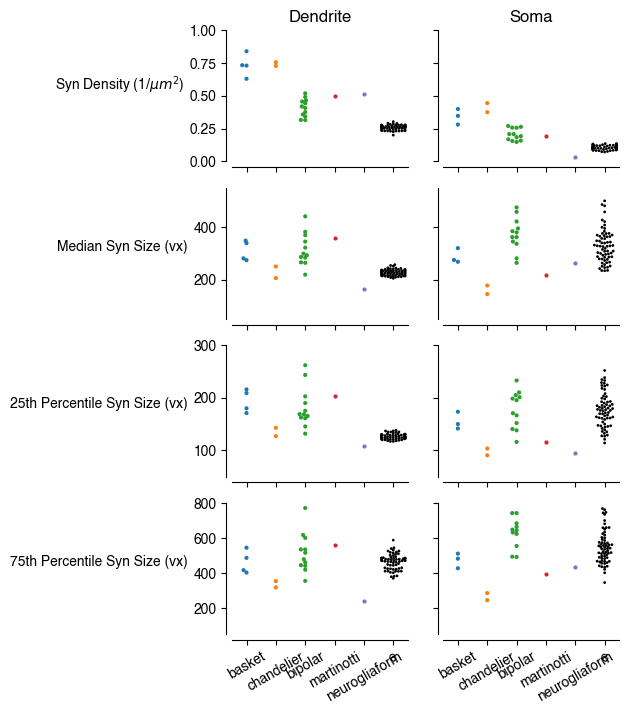

In [32]:
fig, axes = plt.subplots(figsize=(5, 8), nrows=4, ncols=2, facecolor='w', sharey='row', dpi=100)

ax = axes[0, 0]
sns.swarmplot(x='cell_type', y='syn_density_dend', data=nrn_df_red.query('soma_qc>-1 and cell_type!="e"'), size=3, hue_order=hue_order, palette=pal_dict, ax=ax)
sns.swarmplot(x='cell_type', y='syn_density_dend', data=nrn_df_red.query('soma_qc>-1 and cell_type=="e"'), size=2, hue_order=hue_order, palette=pal_dict, ax=ax)

sns.despine(ax=ax, offset=4)
ax.set_ylim(0, 1)
ax.set_ylabel('Syn Density (1/$\mu m^2$)', rotation='horizontal', ha='right')
ax.set_xlabel('')
ax.set_xticklabels('')
ax.set_title('Dendrite')

ax = axes[1, 0]
sns.swarmplot(x='cell_type', y='synapse_size_dend_p50', data=nrn_df_red.query('soma_qc>-1 and cell_type!="e"'), size=3, hue_order=hue_order, palette=pal_dict, ax=ax)
sns.swarmplot(x='cell_type', y='synapse_size_dend_p50', data=nrn_df_red.query('soma_qc>-1 and cell_type=="e"'), size=2, hue_order=hue_order, palette=pal_dict, ax=ax)

sns.despine(ax=ax, offset=4)

ax.set_ylim(50,550)
ax.set_ylabel('Median Syn Size (vx)', rotation='horizontal', ha='right')
ax.set_xlabel('')
ax.set_xticklabels('')

ax = axes[0, 1]
sns.swarmplot(x='cell_type', y='syn_density_soma', data=nrn_df_red.query('soma_qc>0 and cell_type!="e"'), size=3, hue_order=hue_order, palette=pal_dict, ax=ax)
sns.swarmplot(x='cell_type', y='syn_density_soma', data=nrn_df_red.query('soma_qc>0 and cell_type=="e"'), size=2, hue_order=hue_order, palette=pal_dict, ax=ax)
sns.despine(ax=ax, offset=4)

ax.set_ylim(0, 1)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_xticklabels('')
ax.set_title('Soma')


ax = axes[1, 1]
sns.swarmplot(x='cell_type', y='synapse_size_soma_p50', data=nrn_df_red.query('soma_qc>0 and cell_type!="e"'), size=3, hue_order=hue_order, palette=pal_dict, ax=ax)
sns.swarmplot(x='cell_type', y='synapse_size_soma_p50', data=nrn_df_red.query('soma_qc>0 and cell_type=="e"'), size=2, hue_order=hue_order, palette=pal_dict, ax=ax)

sns.despine(ax=ax, offset=4)

ax.set_ylim(50,550)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_xticklabels('')


ax = axes[2, 0]
sns.swarmplot(x='cell_type', y='synapse_size_dend_p25', data=nrn_df_red.query('soma_qc>-1 and cell_type!="e"'), size=3, hue_order=hue_order, palette=pal_dict, ax=ax)
sns.swarmplot(x='cell_type', y='synapse_size_dend_p25', data=nrn_df_red.query('soma_qc>-1 and cell_type=="e"'), size=2, hue_order=hue_order, palette=pal_dict, ax=ax)

sns.despine(ax=ax, offset=4)

ax.set_ylim(50,300)
ax.set_ylabel('25th Percentile Syn Size (vx)', rotation='horizontal', ha='right')
ax.set_xlabel('')
ax.set_xticklabels('')

ax = axes[2, 1]
sns.swarmplot(x='cell_type', y='synapse_size_soma_p25', data=nrn_df_red.query('soma_qc>0 and cell_type!="e"'), size=3, hue_order=hue_order, palette=pal_dict, ax=ax)
sns.swarmplot(x='cell_type', y='synapse_size_soma_p25', data=nrn_df_red.query('soma_qc>0 and cell_type=="e"'), size=2, hue_order=hue_order, palette=pal_dict, ax=ax)

sns.despine(ax=ax, offset=4)

ax.set_ylabel('')
ax.set_xlabel('')
# ax.set_yticklabels('')
ax.set_xticklabels('')

ax = axes[3, 0]
sns.swarmplot(x='cell_type', y='synapse_size_dend_p75', data=nrn_df_red.query('soma_qc>-1 and cell_type!="e"'), size=3, hue_order=hue_order, palette=pal_dict, ax=ax)
sns.swarmplot(x='cell_type', y='synapse_size_dend_p75', data=nrn_df_red.query('soma_qc>-1 and cell_type=="e"'), size=2, hue_order=hue_order, palette=pal_dict, ax=ax)

sns.despine(ax=ax, offset=4)

ax.set_ylim(50,550)
ax.set_ylabel('75th Percentile Syn Size (vx)', rotation='horizontal', ha='right')
ax.set_xlabel('')

ax = axes[3, 1]
sns.swarmplot(x='cell_type', y='synapse_size_soma_p75', data=nrn_df_red.query('soma_qc>0 and cell_type!="e"'), size=3, hue_order=hue_order, palette=pal_dict, ax=ax)
sns.swarmplot(x='cell_type', y='synapse_size_soma_p75', data=nrn_df_red.query('soma_qc>0 and cell_type=="e"'), size=2, hue_order=hue_order, palette=pal_dict, ax=ax)

sns.despine(ax=ax, offset=4)

ax.set_ylim(50,800)
ax.set_ylabel('')
ax.set_xlabel('')


for l in axes[3,1].get_xticklabels():
    l.set_rotation(30)
for l in axes[3,0].get_xticklabels():
    l.set_rotation(30)
    

Text(0.5, 0, 'PCA 2')

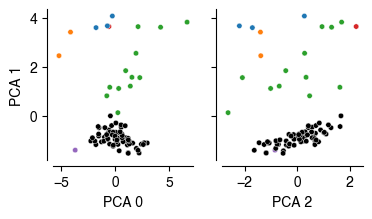

In [34]:
fig, ax = plt.subplots(ncols=2, figsize=(4,2), facecolor='w', dpi=100, sharey=True)

sns.scatterplot(x='pca0', y='pca1', s=15, hue='cell_type', data=nrn_df_red.query('soma_qc>0'), hue_order=hue_order, palette=pal_dict, ax=ax[0])
ax[0].legend().remove()
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles=handles[1:], labels=labels[1:]).set_bbox_to_anchor((1,1))
sns.despine(ax=ax[0], offset=4)

# fig, ax = plt.subplots(figsize=(2,2), facecolor='w', dpi=200)
sns.scatterplot(x='pca2', y='pca1', s=15, hue='cell_type', data=nrn_df_red.query('soma_qc>0'), hue_order=hue_order, palette=pal_dict, ax=ax[1])
handles, labels = ax[1].get_legend_handles_labels()
ax[1].legend().remove()

sns.despine(ax=ax[1], offset=4)
ax[0].set_xlabel('PCA 0')
ax[0].set_ylabel('PCA 1')
ax[1].set_xlabel('PCA 2')


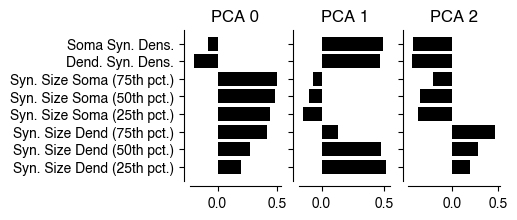

In [36]:
col_labels = {'synapse_size_dend_p50': 'Syn. Size Dend (50th pct.)',
 'synapse_size_dend_p25' : 'Syn. Size Dend (25th pct.)',
 'synapse_size_dend_p75': 'Syn. Size Dend (75th pct.)',
 'synapse_size_soma_p50': 'Syn. Size Soma (50th pct.)',
 'synapse_size_soma_p25': 'Syn. Size Soma (25th pct.)',
 'synapse_size_soma_p75': 'Syn. Size Soma (75th pct.)',
 'syn_density_dend': 'Dend. Syn. Dens.',
 'syn_density_soma': 'Soma Syn. Dens.'}


fig, axes = plt.subplots(ncols=3, figsize=(4,2), facecolor='w', sharey=True, dpi=100)
ax = axes[0]
reorder = [1, 0, 2, 4, 3, 5, 6, 7]
ax.barh(np.arange(len(cols)), pca.components_[0][reorder], color='k')
_ = ax.set_yticks(np.arange(len(cols)))
ax.set_title('PCA 0')
sns.despine(ax=ax, offset=4)


ax = axes[1]
ax.barh(np.arange(len(cols)), pca.components_[1][reorder], color='k')
sns.despine(ax=ax, offset=4)
ax.set_title('PCA 1')

ax = axes[2]
ax.barh(np.arange(len(cols)), pca.components_[2][reorder], color='k')
ax.set_yticklabels([col_labels[cols[ii]] for ii in reorder])
ax.set_title('PCA 2')
sns.despine(ax=ax, offset=4)


Text(0, 0.5, 'Dend. Synapse Density (1/$\\mu m^2$)')

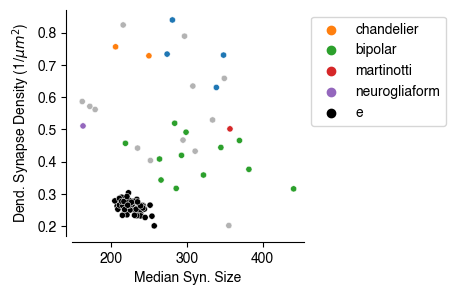

In [38]:
current_palette = sns.color_palette()

current_palette[5] = [0., 0., 0.]
current_palette[6] = [0.7, 0.7, 0.7]
pal_dict = {h:current_palette[ii] for ii, h in enumerate(hue_order+['unknown_type'])}

fig, ax = plt.subplots(figsize=(3,3), facecolor='w', dpi=100)
sns.scatterplot(x='synapse_size_dend_p50', y='syn_density_dend', hue='cell_type', s=20, hue_order=hue_order, data=nrn_df.query('soma_qc>-1'), palette=pal_dict)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:]).set_bbox_to_anchor((1,1))

sns.despine(ax=ax, offset=4)
ax.set_xlabel('Median Syn. Size')
ax.set_ylabel('Dend. Synapse Density (1/$\mu m^2$)')

### All inhibitory cell inputs

Individual synapse data for all inputs onto the interneurons (57821). This data was collected into the dataframes used above.

#### syn_df

* id : Unique id of the synapse
* pre_pt_position : Location of the presynaptic site of the synapse in voxels.
* pre_pt_root_id : Root id of the presynaptic axon
* ctr_pt_position : Location of the synaptic cleft in voxels.
* post_pt_position : Location of the postsynaptic site of the synapse in voxels.
* post_pt_root_id : Root id of the postsyaptic cell (the interneuron).
* size : Size of the synaptic cleft measured in voxels.
* dist_to_root : Distance to the root for the synapse, measured in nm. Note that the distance includes a 15 µm from the base of each dendritic branch to the center point.
* cell_type : Cell type of the postsynaptic interneuron.
* soma_qc : Soma qc for the postsynaptic neuron, same as in `nrn_df`.

In [39]:
syn_df = pd.read_hdf(f'{data_dir}/all_inhib_inputs.h5', 'data')
syn_df.head()

,id,pre_pt_position,pre_pt_root_id,ctr_pt_position,post_pt_position,post_pt_root_id,size,dist_to_root,cell_type,soma_qc
0,3376065,"[93862, 59184, 1651]",648518346349531742,"[93888, 59149, 1650]","[93878, 59102, 1652]",648518346349477331,306.0,46598.193718,bipolar,1
1,3380770,"[97406, 71098, 1891]",648518346344077741,"[97430, 71054, 1888]","[97430, 71010, 1891]",648518346349477331,255.0,30798.437455,bipolar,1
2,3377942,"[86242, 74080, 1871]",648518346341402661,"[86275, 74044, 1871]","[86276, 74006, 1873]",648518346349477331,97.0,22320.973877,bipolar,1
3,3376010,"[94064, 57126, 1614]",648518346342916142,"[93973, 57242, 1617]","[93930, 57106, 1613]",648518346349477331,442.0,53411.957466,bipolar,1
4,3542592,"[92162, 52402, 1539]",648518346346313123,"[92238, 52416, 1539]","[92258, 52436, 1538]",648518346349477331,194.0,72791.190434,bipolar,1
